This is a test

In [2]:
2 + 2 # This is some code

4

In [3]:
using DiffEqFlux, OrdinaryDiffEq, Flux, Optim
using Plots
pyplot(aspect_ratio=:equal)

Plots.PyPlotBackend()

In [4]:
### GENERATE DATA 

ϵ = 0.3
t_final = 4.0
n_data = 60

function spiral_x(t)
    x = (t + 1)*cos(t)
    return Float32(x)
end

function spiral_y(t)
    y = (t + 1)*sin(t)
    return Float32(y)
end

t_data = range(0,stop=t_final,length=n_data)
x_data = spiral_x.(t_data) + ϵ*rand(n_data)
y_data = spiral_y.(t_data) + ϵ*rand(n_data)

data = zeros(2,n_data)
for ti=1:n_data
    data[1,ti] = x_data[ti]
    data[2,ti] = y_data[ti]
end

In [8]:


### SET UP NEURAL ODE

u0 = Float32[1.0; 0.0]
datasize = n_data
tspan = (0.0f0, Float32(t_final))
tsteps = t_data

n_dims = length(u0)
width = 20

model = FastChain(FastDense(n_dims, width, tanh),
                  FastDense(width, n_dims))
prob_neuralode = NeuralODE(model, tspan, Tsit5(), 
                           saveat = tsteps,
                           relerr = 1e-6, abserr = 1e-6)

function predict_neuralode(p)
  Array(prob_neuralode(u0, p))
end

function loss_neuralode(p)
    pred = predict_neuralode(p)
    loss = sum(abs2, data .- pred)
    return loss, pred
end

iter = 0
callback = function (p, l, pred; doplot = true)
  global iter
  iter += 1

  if doplot && (mod(iter,10) == 0)
    IJulia.clear_output(true) #Passing true says to wait until new ouput before clearing, this prevents flickering
    plt = scatter(data[1,1:size(pred,2)], data[2,1:size(pred,2)], label = "data",title = string("iter: ",iter))
    scatter!(plt, pred[1,1:size(pred,2)], pred[2,1:size(pred,2)], label = "prediction")
    plot(plt) |> IJulia.display
  end

  return false
end

#4 (generic function with 1 method)

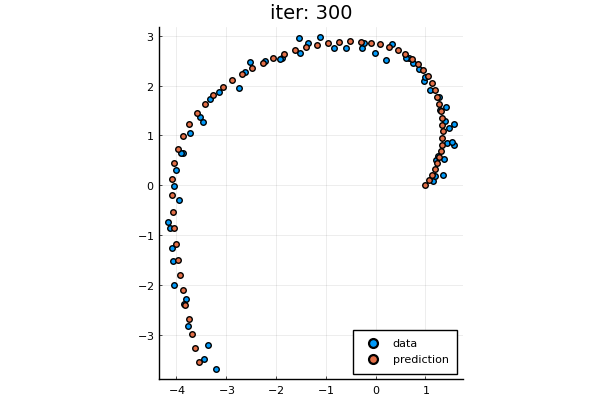

loss: 1.97: 100%|███████████████████████████████████████| Time: 0:00:21


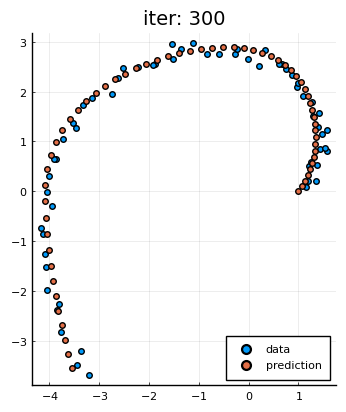

 * Status: success

 * Candidate solution
    Final objective value:     1.972711e+00

 * Found with
    Algorithm:     ADAM

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   22  (vs limit Inf)
    Iterations:    300
    f(x) calls:    300
    ∇f(x) calls:   300


In [9]:
result_neuralode = DiffEqFlux.sciml_train(loss_neuralode, prob_neuralode.p,
                                          ADAM(0.05), cb = callback,
                                          maxiters = 300)

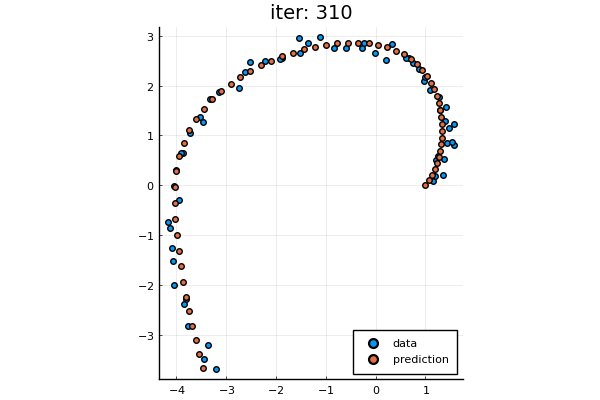

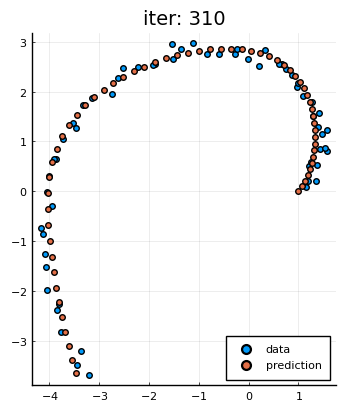

 * Status: success

 * Candidate solution
    Final objective value:     1.471413e+00

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 7.73e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    8
    f(x) calls:    132
    ∇f(x) calls:   132


In [10]:
result_neuralode2 = DiffEqFlux.sciml_train(loss_neuralode,
                                           result_neuralode.minimizer,
                                           LBFGS(),
                                           cb = callback,
                                           allow_f_increases = false)